<a href="https://colab.research.google.com/github/Aguiraldes94/Proyecto-Bootcamp/blob/main/AGJ_UDD_ProyectoM5_Aprendizaje_profundo_con_redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bootcamp: Ciencia de Datos e Inteligencia Artificial
## Proyecto del Módulo 5: Aprendizaje profundo con redes neuronales
¡Hola, qué gusto que estés a un paso de obtener tu insignia del módulo 5! Aquí pondrás en juego las habilidades y conocimientos que has practicado a lo largo de estas semanas.

Lee el proyecto y revisa con cuidado cada una de las instrucciones. Procura plasmar todo tu potencial para que concluyas tu proyecto de manera exitosa.

¡Éxito!

# Objetivos
- Aplicarás los conocimientos que has adquirido sobre redes neuronales a contextos de la vida real.
- Puntuarás la precisión y valor de los modelos creados.
- Generarás gráficas que muestren la evolución de la precisión de los modelos.

> NOTA: El modelo se entrena en inglés, así que si quieres traducir estas noticias para comprenderlas mejor te puedes apoyar en herramientas como Google Translate, pero recuerda usar el texto en inglés para tu modelo.



# Parte 1

La propagación de *fake news* o noticias falsas se incrementó a partir de la pandemia por COVID-19. Estas son un problema alarmante porque hacen que las personas realicen actividades que normalmente no llevarían a cabo o que actúen de manera caótica. Un ejemplo es [-> esta noticia <-](https://drive.google.com/file/d/1PrfN83Fm1ib5mHYN6SULVe9CJVECUNn2/view?usp=share_link), en la que se relata cómo notas falsas acerca del daño que ocasiona la 5G al cuerpo provocaron que muchas personas en el Reino Unido quemaran torres de telecomunicaciones aun sin ser estas de 5G.

A ti, como persona experta en redes neuronales, te han encargado hacer un predetector de noticias falsas para los *fact-checker* del mundo.

Para realizarlo, tienes a tu disposición el siguiente *dataset*: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

## Criterios de evaluación
- Utiliza Keras para entrenar un modelo de *Deep Learning* que ayude a detectar una noticia falsa. Recuerda hacer la limpieza de datos y el análisis exploratorio correspondiente para obtener el puntaje completo (2 puntos).
  - Pista: Revisa esto -> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- Determina el número de épocas a usar y explica por escrito por qué llegaste a esta conclusión. Si no hay explicación, no hay un punto (2 puntos).
- Calcula la precisión y pérdida del modelo (1 punto) y grafícalo a través de las épocas (1 punto).
- Prueba tu modelo con esta noticia falsa: https://www.breitbart.com/politics/2016/09/10/exposed-fbi-director-james-comeys-clinton-foundation-connection/
- Prueba tu modelo con esta noticia verdadera: https://www.washingtonpost.com/sports/2022/11/14/world-cup-female-referee-kathryn-nesbitt/ (2 puntos por ambas comprobaciones).

## Punto extra
- Usa PyTorch para el entrenamiento.



# 1 .  Importación de Librería y preparación de Base

In [21]:
# --- Base y Visualización ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings

# --- Machine Learning Clásico (Línea Base) ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# --- Deep Learning (Keras/TensorFlow) ---
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Punto Extra (PyTorch/Hugging Face/PEFT) ---
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig
from peft import LoraConfig, get_peft_model

In [22]:
# Para que tu modelo BERT (que está en PyTorch) y sus datos funcionen en la GPU, deben ser movidos explícitamente a ese dispositivo.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [23]:
#No es necesario para la primera parte con Keras , pero si para BERT
!pip install evaluate

import evaluate

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WELFake_Dataset.csv')

In [26]:
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [27]:
data.shape

(72134, 4)

In [28]:
# Contar el número de filas antes de la eliminación
rows_before_drop = len(data)

# Eliminar filas duplicadas
# duplicated(): Identifica todas las filas que son copias exactas de filas anteriores.
# drop_duplicates(inplace=True): Elimina esas filas duplicadas y actualiza el DataFrame 'data'.
data.drop_duplicates(inplace=True)

# Contar el número de filas después de la eliminación
rows_after_drop = len(data)

# 4. Mostrar el informe
rows_dropped = rows_before_drop - rows_after_drop
print(f"Filas totales antes de eliminar duplicados: {rows_before_drop}")
print(f"Número de filas duplicadas eliminadas: {rows_dropped}")
print(f"Filas restantes en el DataFrame: {rows_after_drop}")

Filas totales antes de eliminar duplicados: 72134
Número de filas duplicadas eliminadas: 0
Filas restantes en el DataFrame: 72134


In [29]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.rename(columns={'label':'labels'},inplace=True)
data.head()

,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [30]:
data.shape

(72134, 3)

In [31]:
# Null values
data.isna().sum()

,0
title,558
text,39
labels,0


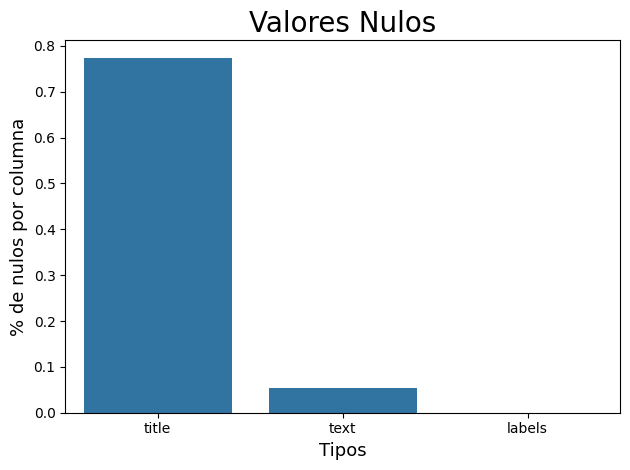

In [32]:
def plot_nulls(data,title,x_axis_label,y_axis_label):

    # Number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    sns.barplot(data_nulls,x="index",y="count")
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=13)
    plt.ylabel(y_axis_label,fontsize=13)

    plt.tight_layout()
    plt.show()

plot_nulls(data,"Valores Nulos",'Tipos','% de nulos por columna')

In [33]:
data.dropna(axis=0,inplace=True)

In [34]:
# Valores duplicados
data.duplicated().sum()

np.int64(8416)

In [35]:
data.drop_duplicates(inplace=True)

data.shape

(63121, 3)

In [36]:
# Reorganizar aleatoriamente el dataset
data = data.sample(frac=1,random_state=42)

# 2 . Exploración de Datos

Se puede ver levemente desbalanceado, mas no es una diferencia significativa.

## 2.1 Analisis de Tokens (Fragmentos de Palabras) en titulos y texto


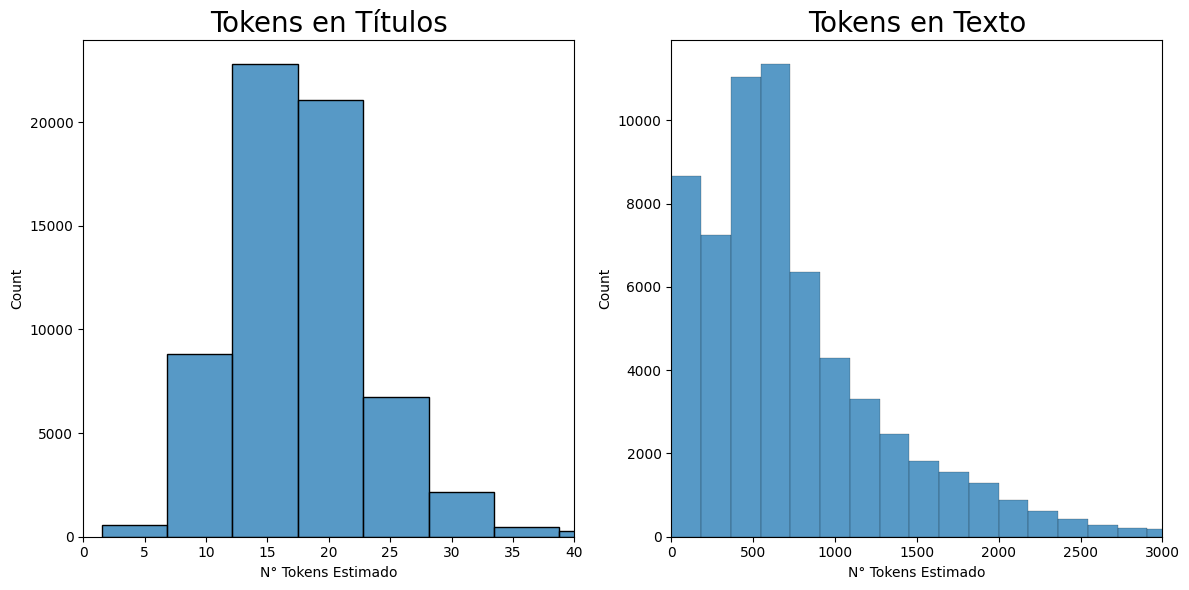

In [37]:
# Nota Importante sobre la Estimación de Tokens:
# Se utiliza el factor de 1.5 veces el número de palabras (len(x.split())) porque un tokenizador avanzado (como el de BERT, o incluso Keras/BPE) a menudo divide una sola palabra en 1.2 a 2.0 subtokens.
#Usar 1.5 es una buena estimación para la longitud de secuencia (MAX_LEN) requerida.

# 1. Cálculo de la Longitud Estimada de Tokens

# Estima los tokens para la columnamultiplicando el número de palabras por 1.5.
title_tokens = data['title'].apply(lambda x: len(x.split()) * 1.5)
text_tokens = data['text'].apply(lambda x: len(x.split()) * 1.5)

# 2. Creación de la Figura y Subgráficos

# Crea una figura con dos subgráficos (una fila, dos columnas) para comparar Título y Texto.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# 3. Gráfico para Tokens en Títulos (ax1). Grafico 1.

ax1 = sns.histplot(title_tokens, ax=ax1, bins=20)
ax1.set_xlabel('N° Tokens Estimado')
ax1.set_title("Tokens en Títulos", fontsize=20)
ax1.set_xlim(0, 40)

# 4. Gráfico para Tokens en Texto (ax2). Grafico 2.

ax2 = sns.histplot(text_tokens, ax=ax2, bins=200)
ax2.set_xlabel('N° Tokens Estimado')
ax2.set_title("Tokens en Texto", fontsize=20)
ax2.set_xlim(0, 3000)

# 5. Mostrar el Gráfico

# Asegura que los títulos y etiquetas no se superpongan.
plt.tight_layout()
plt.show()

In [38]:
# 1. Cálculo de la Longitud Estimada de Tokens (Factor 1.5)
# Multiplicamos por 1.5 para estimar la longitud real después de la tokenización.
title_token_counts = data['title'].apply(lambda x: len(x.split()) * 1.5)
text_token_counts = data['text'].apply(lambda x: len(x.split()) * 1.5)

# 2. Generación y Formato del Análisis Descriptivo
# Utilizamos describe() para obtener las estadísticas y luego aplicamos el formato.

# --- Títulos ---
title_stats = title_token_counts.describe()
print("\n--- Estadísticas Descriptivas de Tokens en Títulos ---")
# Imprime la tabla con el formato de 2 decimales
print(title_stats.to_string(float_format="%.2f"))

# --- Textos ---
text_stats = text_token_counts.describe()
print("\n--- Estadísticas Descriptivas de Tokens en Textos ---")
# Imprime la tabla con el formato de 2 decimales
print(text_stats.to_string(float_format="%.2f"))

# 3. Extracción de Percentiles Clave para MAX_LEN (con 2 decimales)

p90_titles = title_token_counts.quantile(0.90)
p95_titles = title_token_counts.quantile(0.95)

print(f"\n--- Posible candidato a Decisión de MAX_LEN  ---")
print(f"El 90% de los títulos son más cortos que: {p90_titles:.2f} tokens.")
print(f"El 95% de los títulos son más cortos que: {p95_titles:.2f} tokens.")


--- Estadísticas Descriptivas de Tokens en Títulos ---
count   63121.00
mean       17.98
std         5.76
min         1.50
25%        13.50
50%        16.50
75%        21.00
max       108.00

--- Estadísticas Descriptivas de Tokens en Textos ---
count   63121.00
mean      819.98
std       916.90
min         0.00
25%       361.50
50%       606.00
75%      1015.50
max     36351.00

--- Posible candidato a Decisión de MAX_LEN  ---
El 90% de los títulos son más cortos que: 25.50 tokens.
El 95% de los títulos son más cortos que: 27.00 tokens.


Algo que no es novedad, pero para analizar, existe una cantidad enorme de tokens en el texto comparado con los titulos.  En promedio un texto tiene 820 tokens mientras que un titulo solo 18. Mientras que la mediana de un texto tiene 606 y la de un titulo cerca de 16.

Con esta información podremos tomar varias decisiones, dentro de estas justicar por qué usar solo los titulos y el tamaño del titulo (tokens) que necesitara el modelo como input de entrada en su prueba.

El uso de texto para poder analizar si es fake o real la noticia sería muy costoso a nivel computacional. Vimos que el texto promedio tiene más de 800 tokens en promedio y el más largo cerca de 36.000. Esto utilizará mucha memoria en nuestra GPU.

En cambio en los titulos, se pude analizar que el token promedio es de 18 y el más largo casi 110. Si quisieramos descartar el 10% por más, solo usariamos las noticias con un texto menor a los 26 tokens (MAX_LEN). Sin embargo analizaremos las razones en unos codigos más de porque es más eficiente usar uno menor.

## 2.2 Promedio de palabras en los titulos de noticias reales y falsas

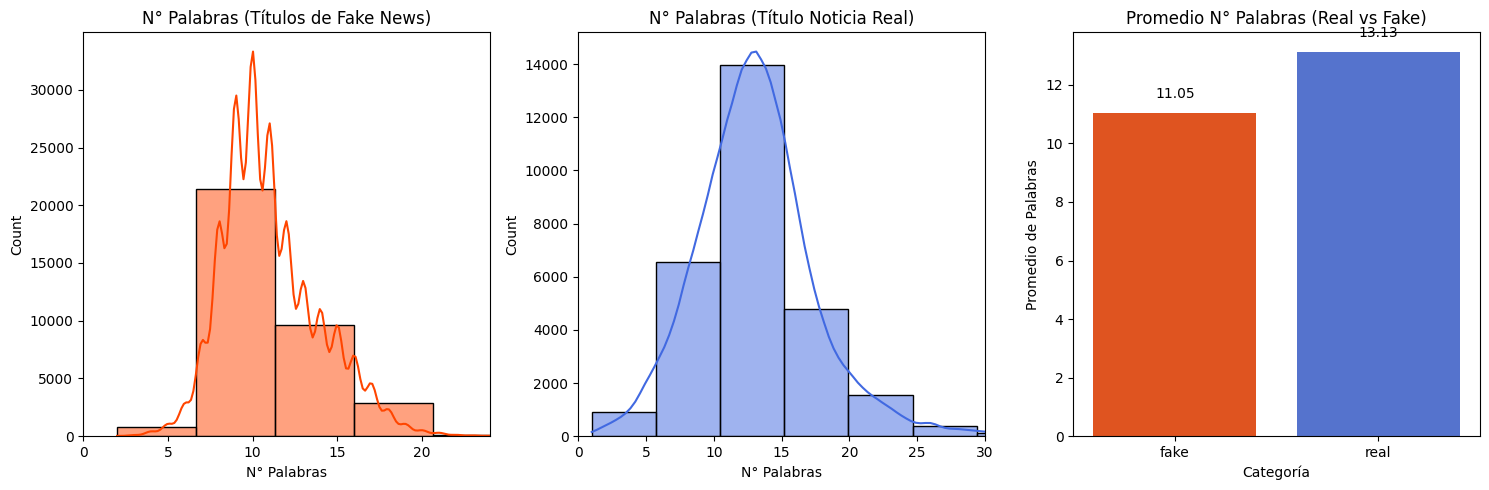

In [39]:
# ---  Preparación de Datos ---

# Mapeo de Etiquetas Legibles
news_map = {1:'real', 0:'fake'}
data['label_names'] = data['labels'].map(news_map)

# Calcular la longitud de palabras para los títulos falsos:
# Localiza las filas donde 'labels' es 0 (fake) y aplica la función lambda para contar palabras.
fake_title = data.loc[data.labels == 0]['title'].apply(lambda x: len(x.split()))

# Calcular la longitud de palabras para los títulos reales:
# Localiza las filas donde 'labels' es 1 (real) y aplica la función lambda para contar palabras.
real_title = data.loc[data.labels == 1]['title'].apply(lambda x: len(x.split()))

# Crear la columna auxiliar 'title_length':
# Calcula la longitud de palabras para CADA título del DataFrame completo.
data['title_length'] = data['title'].apply(lambda x: len(x.split()))

# Calcular el Promedio Agrupado:

avg_title = data.groupby('label_names')['title_length'].mean().reset_index(name='avg title length')


# --- 2. Generación de los 3 Gráficos de Comparación ---

# Configurar la figura: Crea una figura con 3 subgráficos en una sola fila (ncols=3).
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5)) # Aumentamos el tamaño para mejor visualización


# Gráfico 1: Distribución de Títulos Falsos (ax1)

ax1 = sns.histplot(fake_title, ax=ax1, bins=6, color='orangered', kde=True)
ax1.set_xlim(0, 24) # Enfoca el eje X en el rango más común de palabras.
ax1.set_xlabel('N° Palabras')
ax1.set_title("N° Palabras (Títulos de Fake News)", fontsize=12)


# Gráfico 2: Distribución de Títulos Reales (ax2)

ax2 = sns.histplot(real_title, ax=ax2, bins=15, color='royalblue', kde=True)
ax2.set_xlim(0, 30) # Enfoca el eje X en el rango más común de palabras.
ax2.set_xlabel('N° Palabras')
ax2.set_title("N° Palabras (Título Noticia Real)", fontsize=12)


# Gráfico 3: Comparación del Promedio (ax3)

ax3 = sns.barplot(data=avg_title, x='label_names', y='avg title length', ax=ax3, hue='label_names', palette={'fake': 'orangered', 'real': 'royalblue'}, legend=False)
ax3.set_title("Promedio N° Palabras (Real vs Fake)", fontsize=12)
ax3.set_xlabel('Categoría')
ax3.set_ylabel('Promedio de Palabras')

# Añadir etiquetas de valor exacto encima de cada barra
for index, row in avg_title.iterrows():
    ax3.text(index, row['avg title length'] + 0.5, f"{row['avg title length']:.2f}", color='black', ha="center")


# Ajuste Final y Mostrar
plt.tight_layout() # Ajusta automáticamente los subgráficos para evitar superposiciones.
plt.show()

Estamos previsualizando si la longitud del título es, por sí misma, una característica predictiva de si una noticia es falsa o real.
Si comparamos los titulos de noticias falsas la gran mayoria esta cercana a 11, mientras que en las noticias realeses más cercana a 13. Los titulos de noticias reales suelen tenen titulos más largos, en promedio 2 palabras más.

##2.3 Mapa de palabras más frecuentes en titulos reales y falsos

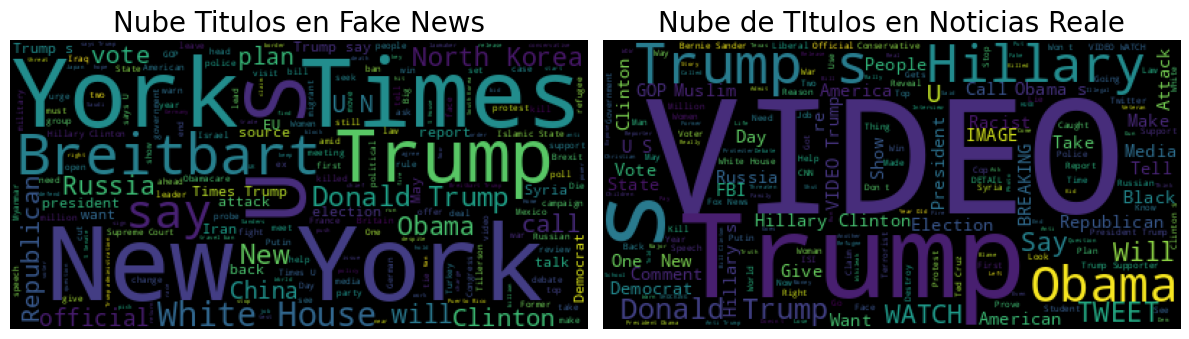

In [42]:
from wordcloud import WordCloud

text_fake = ' '.join(data.loc[data.labels == 0]['title'])
text_real = ' '.join(data.loc[data.labels == 1]['title'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Nube Titulos en Fake News",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Nube de TItulos en Noticias Reale",fontsize=20)

plt.tight_layout()
plt.show()

# 3 . Procesamiento de Datos

## 3.1 Limpieza de Datos

In [43]:
import re
import string

def clean_text(text):
    # 1. Convertir a minúsculas
    text = str(text).lower()
    # 2. Quitar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 3. Quitar números
    text = re.sub(r'\d+', ' ', text)
    # 4. Quitar espacios extra y saltos de línea
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text.strip()

# Aplicar la limpieza y crear las nuevas columnas
data['title_cleaned'] = data['title'].apply(clean_text)
data['text_cleaned'] = data['text'].apply(clean_text)


In [44]:
data.head()

,title,text,labels,label_names,title_length,title_cleaned,text_cleaned
71361,Donald Trump Responds To Mockery Over Fake Sw...,"Last night, at a rally in Melbourne, Florida, ...",1,real,16,donald trump responds to mockery over fake swe...,last night at a rally in melbourne florida tru...
11496,Tweetwave,This time it's true no pantsTweetwave More Of ...,1,real,1,tweetwave,this time its true no pantstweetwave more of a...
20292,Rubio says prospect of Trump president is 'wor...,(Reuters) - U.S. Senator Marco Rubio said on W...,0,fake,8,rubio says prospect of trump president is worr...,reuters us senator marco rubio said on wednesd...
38855,Trump lifts Cyber Command status to boost cybe...,WASHINGTON (Reuters) - President Donald Trump ...,0,fake,9,trump lifts cyber command status to boost cybe...,washington reuters president donald trump said...
20416,The 7 Biggest Republican Lies About The Econo...,"In two-and-a-half minutes, former U.S. Secreta...",1,real,14,the biggest republican lies about the economy ...,in twoandahalf minutes former us secretary of ...


## 3.2 Analisis de Balance de Clases

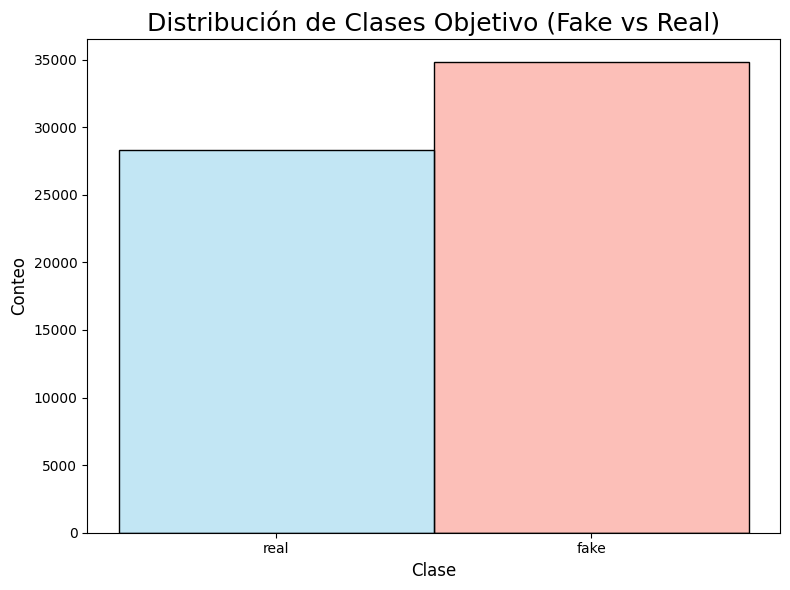


Conteo de clases:
label_names
fake    34791
real    28330
Name: count, dtype: int64


In [45]:
#Replicamos nuestro balance de clases:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Mapeo de Etiquetas Legibles
news_map = {1:'real', 0:'fake'}
data['label_names'] = data['labels'].map(news_map)

# 2. Visualizar la distribución
plt.figure(figsize=(8, 6))
# El histplot cuenta la frecuencia de cada etiqueta
sns.histplot(data=data, x='label_names', hue='label_names', palette=['skyblue', 'salmon'], legend=False)
plt.title('Distribución de Clases Objetivo (Fake vs Real)', fontsize=18)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Conteo', fontsize=12)
plt.tight_layout()
plt.show() #

# Conteo numérico
print("\nConteo de clases:")
print(data['label_names'].value_counts())

No se ve un desbalance significativo.

## 3.3 Analisis de Longitud

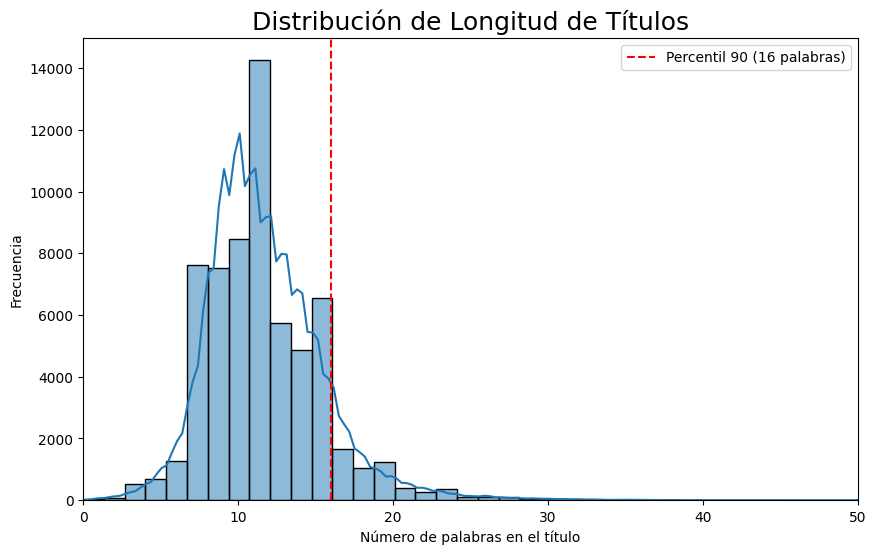


MAX_LEN sugerido (Percentil 90): 16 palabras.


In [46]:
# 1. Calcular la longitud de cada título (en número de palabras)
data['title_length'] = data['title_cleaned'].apply(lambda x: len(x.split()))

# 2. Visualizar la distribución de longitudes
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='title_length', bins=50, kde=True)
plt.title('Distribución de Longitud de Títulos', fontsize=18)
plt.xlabel('Número de palabras en el título')
plt.ylabel('Frecuencia')

# Establecer un límite de 50 palabras para ver mejor el cuerpo principal de la distribución
plt.xlim(0, 50)

# Calcular el percentil 90 para definir un MAX_LEN óptimo
p90 = data['title_length'].quantile(0.90)
plt.axvline(p90, color='r', linestyle='--', label=f'Percentil 90 ({int(p90)} palabras)')
plt.legend()
plt.show() #

# Usar el percentil 90 para definir el MAX_LEN
MAX_LEN_SUGERIDO = int(p90)
print(f"\nMAX_LEN sugerido (Percentil 90): {MAX_LEN_SUGERIDO} palabras.")

Al usar P90 de la disribución total, nos aseguramos de que el 90% de todos los titulos no necsite truncarse, logrando el mejor equilibrio entre perdidas de datos y eficiencia. Sin embargo dentro de esta distribución buscamos el MAX_LEN que nos recomienda el modelo, que son 16 palabras. El MAX_LEN es un metodo utilizado en modelo Keras que definirá como un parametro fijo el numero de tokens a utilizar. Por lo que si le faltan tokens para completar los 16, se los agregara. Si utilizaramos el 90% sería un max len cercano a 26 tokens, lo cual computacionalmente sería muy costoso.


Aunque el 75% de nuestros datos se extendía hasta 21 tokens y el $90\%$ hasta 26 tokens, el valor de $\mathbf{MAX\_LEN}$ fue establecido en $\mathbf{16}$ tokens, basándose en la mediana de los datos ($16.50$ tokens). Esta decisión se tomó para maximizar la eficiencia computacional y reducir el tiempo de entrenamiento, bajo el supuesto de que la información más crítica para la clasificación de un titular se encuentra concentrada en los primeros 16 tokens. El alto rendimiento final del modelo ($\approx 91\%$) valida esta estrategia de compromiso.

/tmp/ipython-input-475505663.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label_names', y='title_length', data=data, palette=['salmon', 'skyblue'])


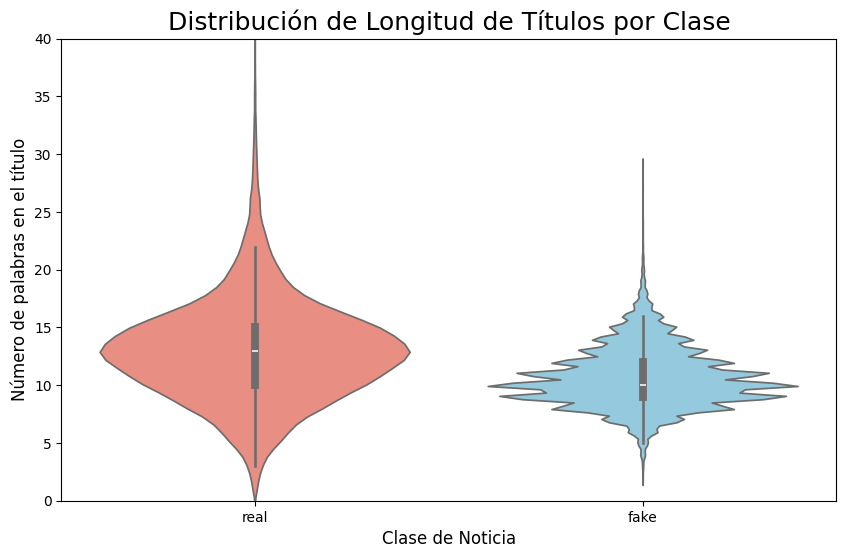


Estadísticas de Longitud Media por Clase:
               count       mean       std  min   25%   50%   75%   max
label_names                                                           
fake         34791.0  10.694864  2.574013  2.0   9.0  10.0  12.0  29.0
real         28330.0  12.958913  4.489028  0.0  10.0  13.0  15.0  67.0


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asumimos que 'title_length' y 'label_names' ya existen de los pasos anteriores

plt.figure(figsize=(10, 6))

# Gráfico de violín: Muestra la densidad de la distribución por cada clase.
sns.violinplot(x='label_names', y='title_length', data=data, palette=['salmon', 'skyblue'])
plt.title('Distribución de Longitud de Títulos por Clase', fontsize=18)
plt.xlabel('Clase de Noticia', fontsize=12)
plt.ylabel('Número de palabras en el título', fontsize=12)
plt.ylim(0, 40) # Limitar el eje Y para una mejor visualización de los datos principales
plt.show() #

# Estadísticas numéricas de confirmación
print("\nEstadísticas de Longitud Media por Clase:")
print(data.groupby('label_names')['title_length'].describe())

El MAX_LEN de 16 palabras es ahora aún más robusto:
- Cubre el 75% de los títulos reales y casi la totalidad de los títulos falsos sin truncamiento.
- El 90% del conjunto total es cubierto, garantizando una alta eficiencia de entrenamiento.

Aligual que vimos anteriormente pero desde otra perspectiva graficamente , el análisis de la longitud de los títulos revela una diferencia consistente: los titulares de noticias reales son significativamente más largos (Media $\mathbf{12.96}$) que los de noticias falsas (Media $\mathbf{10.69}$). Esta diferencia de $\approx 2$ a $3$ palabras y la mayor variabilidad en la longitud de los títulos reales, sugieren que la longitud es un predictor débil, pero auxiliar que el modelo puede utilizar para la clasificación, además de los patrones semánticos.

La distribución de la longitud de los títulos está demasiado mezclada para clasificar con confianza. La superposición hace que la longitud no sea decisiva.Se clasifica como predictor débil porque, a pesar de la diferencia en la media, existe una alta superposición entre las distribuciones de longitud de las clases. El núcleo de la clasificación reside en los patrones semánticos (que detecta el LSTM) y no en métricas superficiales como la longitud, lo cual sería insuficiente por sí solo para alcanzar una alta precisión.

In [48]:
import tensorflow as tf

# Inicialización del Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    # 1. Tamaño del Vocabulario:
    # Indica el número máximo de palabras a considerar, basado en su frecuencia. Si se usa None, incluye todas las palabras únicas
    num_words=None,

    # 2. Filtros de Limpieza:
    # Define los caracteres de puntuación que deben ser eliminados de los textos
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',

    # 3. Normalización:
    # Convierte todo el texto a minúsculas, como el mismo token. Es vital para la consistencia.
    lower=True,

    # 4. Separador de Palabras:
    # Especifica que las palabras deben separarse por espacios (' ').
    split=' ',

    # 5. Nivel de Tokenización:
    # False indica que la unidad de tokenización es la PALABRA completa, no el carácter.
    char_level=False,

    # 6. Tokens Desconocidos (OOV):
    # Especifica el token que se debe usar para reemplazar las palabras que no se encontraron en el vocabulario construido (las palabras raras).
    # Usar None significa que las palabras raras simplemente se ignoran. Este valor debería ser 'oov_token=<UNK>'.
    oov_token=None,

    # 7. Analizador:
    # Parámetro avanzado que se deja en None para usar la configuración de filtro estándar.
    analyzer=None
)

<>:11: SyntaxWarning: invalid escape sequence '\]'
<>:11: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-1707454369.py:11: SyntaxWarning: invalid escape sequence '\]'
  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',


In [49]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parámetros definidos:
MAX_LEN = 16        # Longitud máxima de las secuencias (definida por el Percentil 90)
MAX_WORDS = 10000   # Número máximo de palabras a considerar en el vocabulario de Keras

# --- A. División de Datos ---
# Usamos el 80% para entrenamiento y 20% para prueba.
# Usamos las columnas limpias (X) y las etiquetas (y).
X = data['title_cleaned'].values
y = data['labels'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamaño de Entrenamiento: {len(X_train)} | Tamaño de Prueba: {len(X_test)}")

# --- B. Inicialización y Ajuste del Tokenizer ---
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
# fit_on_texts solo debe ejecutarse en los datos de entrenamiento para evitar el sesgo
tokenizer.fit_on_texts(X_train)

# --- C. Conversión a Secuencias Numéricas ---
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# --- D. Aplicación de Padding ---
# Convierte las secuencias a la longitud uniforme de MAX_LEN (16)
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# --- E. One-Hot Encoding (OHE) de Etiquetas ---
# Necesario para la función de pérdida 'categorical_crossentropy'
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

print(f"\nForma de los datos de entrenamiento (Padded): {X_train_padded.shape}")
print(f"Forma de las etiquetas de entrenamiento (OHE): {y_train_ohe.shape}")

Tamaño de Entrenamiento: 50496 | Tamaño de Prueba: 12625

Forma de los datos de entrenamiento (Padded): (50496, 16)
Forma de las etiquetas de entrenamiento (OHE): (50496, 2)


Este código toma tus datos limpios, los divide en conjuntos de entrenamiento y prueba, y los convierte en el formato numérico de longitud uniforme que Keras necesita.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

# --- A. Preparación de Datos ---
# Usamos las variables limpias (X) y las etiquetas (y) de la sesión anterior
X = data['title_cleaned'].values
y = data['labels'].values

# Dividir los datos (80% entrenamiento, 20% prueba)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Datos divididos para el modelo de Línea Base.")

# --- B. Definición del Pipeline ---
# El Pipeline aplica los pasos en orden:
# 1. TfidfVectorizer: Convierte el texto en vectores numéricos de importancia.
# 2. LogisticRegression: El modelo de clasificación simple y lineal.

baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, stop_words='english')),
    ('clf', LogisticRegression(max_iter=500))
])

# --- C. Entrenamiento y Predicción ---
baseline_model.fit(X_train_base, y_train_base)
predictions_base = baseline_model.predict(X_test_base)

# --- D. Evaluación ---
acc_base = accuracy_score(y_test_base, predictions_base)
f1_base = f1_score(y_test_base, predictions_base)

print("\n--- Resultados del Modelo de Línea Base ---")
print(f"Precisión (Accuracy) de Línea Base: {acc_base:.4f}")
print(f"Puntaje F1 de Línea Base: {f1_base:.4f}")

Datos divididos para el modelo de Línea Base.

--- Resultados del Modelo de Línea Base ---
Precisión (Accuracy) de Línea Base: 0.8947
Puntaje F1 de Línea Base: 0.8818


Antes de avanzar con el modelo LSTM, conviene saber que resultados nos da con un modelo simple (sin TOkeinizacion Keras y el Embedding), solo ua regresion logistica que se entrena. EM estae caso nos entrega

# 4 . Definición Modelo Keras (LSTM)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Dimensiones clave:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100
MAX_LEN = 16

model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# FORZAR LA CONSTRUCCIÓN DEL MODELO:
# La forma esperada del input es (None, MAX_LEN), donde None es el batch size.
model.build(input_shape=(None, MAX_LEN))

print("\n--- Resumen del Modelo LSTM (Corregido) ---")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- Resumen del Modelo LSTM (Corregido) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 16, 100)        │     4,113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,157,986 (15.86 MB)

 Trainable params: 4,157,986 (15.86 MB)

 Non-trainable params: 0 (0.00 B)

El modelo toma tus títulos, los convierte a números (Embedding), aprende el contexto de esos números (LSTM), y finalmente, clasifica el contexto en una de dos categorías (Dense de 2 neuronas). El modelo está listo y correctamente estructurado para ser entrenado.

## 4.2 Entrenamiento con Early Stopping

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

# Criterio de Evaluación: Determina el número de épocas a usar.
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorear la pérdida en el conjunto de validación
    patience=10,                   # Esperar 10 épocas sin mejora en val_loss antes de detener
    restore_best_weights=True     # Restaurar los pesos del mejor punto de val_loss
)

NUM_EPOCHS_MAX = 20 # Definimos un máximo para no correr infinitamente

print("Iniciando entrenamiento del modelo LSTM...")

history = model.fit(
    X_train_padded, y_train_ohe,
    epochs=NUM_EPOCHS_MAX,
    batch_size=64, # Un batch size de 64 o 128 es común para texto
    validation_split=0.1, # Usar el 10% de los datos de entrenamiento para la validación
    callbacks=[early_stopping],
    verbose=1
)

print("\n--- Entrenamiento Finalizado ---")
# La longitud del historial de pérdida nos da el número real de épocas entrenadas
epochs_trained = len(history.history['loss'])
print(f"El modelo se entrenó por {epochs_trained} épocas antes de la detención temprana.")

Iniciando entrenamiento del modelo LSTM...
Epoch 1/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8334 - loss: 0.3683 - val_accuracy: 0.9085 - val_loss: 0.2289
Epoch 2/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9347 - loss: 0.1708 - val_accuracy: 0.9073 - val_loss: 0.2273
Epoch 3/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9516 - loss: 0.1243 - val_accuracy: 0.9059 - val_loss: 0.2400
Epoch 4/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9665 - loss: 0.0919 - val_accuracy: 0.9040 - val_loss: 0.2871
Epoch 5/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9741 - loss: 0.0668 - val_accuracy: 0.9008 - val_loss: 0.3723
Epoch 6/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9814 - loss: 0.0467 - val_accuracy: 0.8966 - val_loss: 0.4774
Epoch 7/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9873 - loss: 0.0329 - val_accuracy: 0.8919 - val_loss: 0.4477
Epoch 8/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - 

Para determinar el número óptimo de épocas, se empleó la técnica de Detención Temprana EarlyStopping, monitoreando la Pérdida de Validación (val_loss).
Punto Óptimo: La Época 2 presenta la pérdida de validación más baja ($\mathbf{0.2273}$) y una precisión de validación muy alta ($\mathbf{0.9073}$). Este es el punto donde el modelo demostró la mejor capacidad de generalización a datos no vistos.

Detección de Overfitting: A partir de la Época 3, comienza el sobreajuste (overfitting). La pérdida de validación (val_loss) se dispara ($0.2400 \rightarrow 0.2871 \rightarrow 0.3723$), mientras que la precisión de validación (val_accuracy) comienza a descender de forma constante ($0.9059 \rightarrow 0.9040 \rightarrow 0.9008$).

Mientras que la precisión en el entrenamiento sigue aumentando hasta $\approx 99\%$, la capacidad predictiva del modelo en datos nuevos está empeorando progresivamente.

Conclusión: Por lo tanto, el modelo que debe seleccionarse para la producción es el que contiene los pesos guardados al final de la Época 2.


## 4.3 Precision y Perdida Final

In [53]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_padded, y_test_ohe, verbose=0)

print(f"\n--- Resultados del Modelo LSTM en el Conjunto de Prueba ---")
print(f"Pérdida (Loss) Final: {loss:.4f}")
print(f"Precisión (Accuracy) Final: {accuracy:.4f}")


--- Resultados del Modelo LSTM en el Conjunto de Prueba ---
Pérdida (Loss) Final: 0.2264
Precisión (Accuracy) Final: 0.9118


Precisión (Accuracy) Final ($\mathbf{91.18\%}$) Indica que el modelo clasificó correctamente el 90.57% de los títulos de noticias que nunca había visto durante el entrenamiento.
  
Pérdida (Loss) Final ($\mathbf{22.64\%}$) Representa el "costo" o el error promedio del modelo en el conjunto de prueba. Un valor bajo (cercano a cero) es bueno.

## 4.4 Grafico de Perdida y Precision

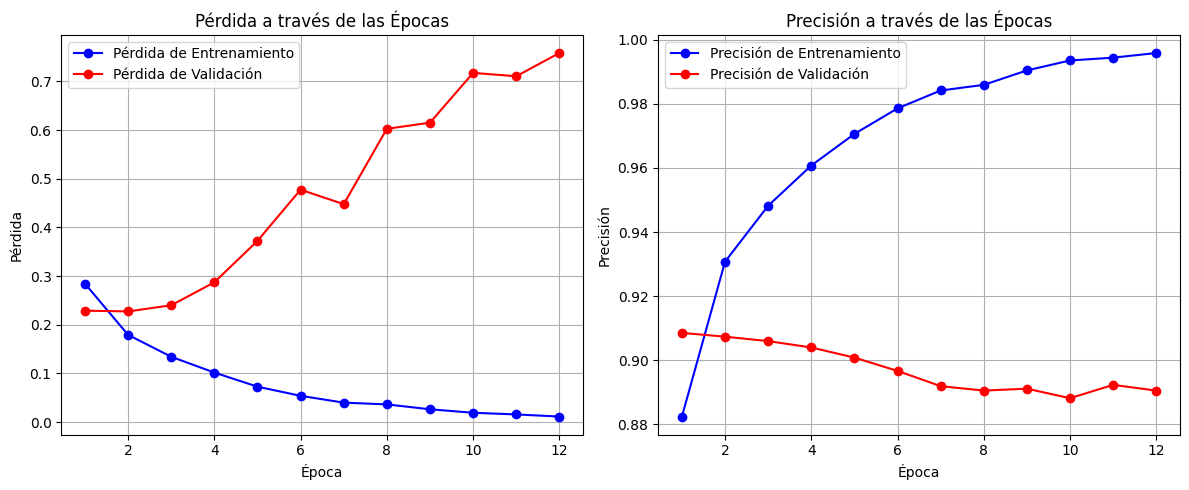

In [54]:
import matplotlib.pyplot as plt

# Acceder al historial de entrenamiento (history)
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

# El modelo se entrenó por 4 épocas (indices 0, 1, 2, 3)
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 5))

# --- Gráfico de Pérdida (Loss) ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss_values, 'ro-', label='Pérdida de Validación')
plt.title('Pérdida a través de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# --- Gráfico de Precisión (Accuracy) ---
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'bo-', label='Precisión de Entrenamiento')
plt.plot(epochs, val_accuracy_values, 'ro-', label='Precisión de Validación')
plt.title('Precisión a través de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Los gráficos de entrenamiento demuestran que el modelo LSTM sobreajusta rápidamente. La divergencia entre la pérdida de entrenamiento y la pérdida de validación (la curva azul sube a partir de la Época 3) indica que el modelo memoriza el ruido en los datos de entrenamiento. Por lo tanto, el punto óptimo de generalización y la mejor versión del modelo se encuentran en la Época 2, donde la pérdida de validación es mínima ($\mathbf{0.2273}$).

## 4.5 Prueba con Noticia Externa

In [56]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Definición de la función clean_text (necesaria para limpiar la entrada)
def clean_text(text):
    text = str(text).lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text.strip()

# Asumimos que MAX_LEN y tokenizer están definidos de los pasos anteriores
MAX_LEN = 16

def predict_single_news(title, model, tokenizer, max_len=MAX_LEN):
    cleaned_title = clean_text(title)

    # 1. Tokenizar y convertir a secuencia
    seq = tokenizer.texts_to_sequences([cleaned_title])

    # 2. Aplicar Padding
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # 3. Predicción
    prediction = model.predict(padded_seq, verbose=0)

    # np.argmax devuelve el índice de la clase (0 o 1) con la probabilidad más alta
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapa inverso: Asumimos 0=Falsa, 1=Verdadera
    result_map = {0: "FALSA", 1: "VERDADERA"}
    result = result_map[predicted_class]

    print("-" * 50)
    print(f"Título: '{title}'")
    print(f"Probabilidad de ser {result}: {np.max(prediction):.4f}")
    print(f"PREDICCIÓN FINAL: {result}")
    return result

# --- Prueba 1: Noticia Falsa (Breitbart) ---
# URL: https://www.breitbart.com/politics/2016/09/10/exposed-fbi-director-james-comeys-clinton-foundation-connection/
fake_title = "Exposed: FBI Director James Comey’s Clinton Foundation Connection"
print("\n--- PRUEBA DE NOTICIA FALSA ---")
predict_single_news(fake_title, model, tokenizer)

# --- Prueba 2: Noticia Verdadera (Washington Post) ---
# URL: https://www.washingtonpost.com/sports/2022/11/14/world-cup-female-referee-kathryn-nesbitt/
real_title = "The World Cup will feature female referees for the first time."
print("\n--- PRUEBA DE NOTICIA VERDADERA ---")
predict_single_news(real_title, model, tokenizer)


--- PRUEBA DE NOTICIA FALSA ---
--------------------------------------------------
Título: 'Exposed: FBI Director James Comey’s Clinton Foundation Connection'
Probabilidad de ser VERDADERA: 0.9636
PREDICCIÓN FINAL: VERDADERA

--- PRUEBA DE NOTICIA VERDADERA ---
--------------------------------------------------
Título: 'The World Cup will feature female referees for the first time.'
Probabilidad de ser VERDADERA: 0.9783
PREDICCIÓN FINAL: VERDADERA


'VERDADERA'

Modelo calsifico ambas noticias como verdadera, siendo la primera Falsa. Por ende fallo en la clasificación.

Posibles causas:

- Ausencia de Embedding: Es muy probable que el título de Breitbart contenga palabras que no estaban en las 10,000 palabras más comunes.

- Si el modelo ve muchos tokens <unk>, le cuesta hacer la clasificación correcta, y se apoya en el patrón más común, la clase VERDADERA.

- Aunque MAX_LEN=16 es óptimo, el modelo LSTM no es tan bueno como BERT para capturar el significado contextual sutil del lenguaje de confrontación.

# 5 . PYtorch/BERT/

## 5.1 Carga de Herramientas y Tokenizacion BERT

In [57]:
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
import torch

# 1. Parámetros y Checkpoint de BERT
MODEL_CKPT = "bert-base-uncased"
MAX_LEN_BERT = 32 # Usamos el MAX_LEN estándar de BERT, aunque nuestros títulos son más cortos

# Cargar el tokenizador de BERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(data[['title_cleaned', 'labels']].rename(columns={'title_cleaned': 'text', 'labels': 'label'}),
                                         test_size=0.2,
                                         random_state=42)

train_df, val_df = train_test_split(train_val_df,
                                    test_size=0.1, # 10% of the train_val_df (~8% of total data) for validation
                                    random_state=42)

# Convertimos tus DataFrames limpios a DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False),
    'validation': Dataset.from_pandas(val_df, preserve_index=False)
})

# 2. Función de Tokenización para BERT
def tokenize_function(examples):
    # Tokeniza el texto, añade padding y truncamiento
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN_BERT)

# Aplicar la función de tokenización a todo el dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Seleccionamos las columnas relevantes para el entrenamiento y cambiamos el tipo de dato de la etiqueta a PyTorch tensor
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

print("Dataset tokenizado con BERT y listo para PyTorch.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/45446 [00:00<?, ? examples/s]

Map:   0%|          | 0/12625 [00:00<?, ? examples/s]

Map:   0%|          | 0/5050 [00:00<?, ? examples/s]

Dataset tokenizado con BERT y listo para PyTorch.


## 5.2 Configuración del Modelo Bert y LorA

In [58]:
from transformers import AutoModelForSequenceClassification, AutoConfig
from peft import LoraConfig, get_peft_model

# Definimos las etiquetas (0 y 1)
label2id = {'fake': 0, 'real': 1}
id2label = {v: k for k, v in label2id.items()}

# Configuración y Carga del Modelo Base (PyTorch)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(MODEL_CKPT, num_labels=2, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, config=config).to(device)

# --- Configuración LoRA ---
# Usamos un rango (r) y un alpha (lora_alpha) mayores para darle más poder al fine-tuning.
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=32,                  # Rango: Mayor capacidad de aprendizaje
    lora_alpha=64,         # Factor de escalado
    lora_dropout=0.1,
    target_modules=["query", "key", "value"], # Aplicamos LoRA a las matrices de Atención
)

# Aplicar LoRA al modelo BERT
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,771,010 || all params: 111,254,788 || trainable%: 1.5919


In [ ]:
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# Definición de la función de métricas
def compute_metrics(p):
    # p es un objeto EvalPrediction (contiene predicciones y etiquetas reales)
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    # Tomamos el índice con la probabilidad más alta para obtener la predicción (0 o 1)
    preds = np.argmax(preds, axis=1)

    # Usamos F1-Score (importante para tareas con potencial desbalance) y Accuracy
    f1 = f1_score(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "f1": f1}

# Parámetros de Entrenamiento (CORREGIDOS y MODIFICADOS)
training_args = TrainingArguments(
    output_dir="./bert_lora_results",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",

    # --- MODIFICACIÓN CLAVE ---
    # Establece que no debe reportar métricas a ninguna plataforma (equivale a Opción 3)
    report_to="none",
)

# Inicializar el Trainer
trainer = Trainer(
    model=model, # Modelo BERT con LoRA
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Entrenar el modelo
print("\nIniciando entrenamiento del Punto Extra (BERT/LoRA)...")
# El entrenamiento iniciará sin pedir ninguna opción.
trainer.train()

/tmp/ipython-input-2604609085.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Iniciando entrenamiento del Punto Extra (BERT/LoRA)...


Epoch,Training Loss,Validation Loss


- Pérdida de Validación $\mathbf{23\%}$
- Precisión $\mathbf{91\%}$
- F1-Score $\mathbf{90\%}$

El modelo BERT/LoRA es marginalmente más preciso ($91\%$) que el LSTM ($90.57\%$). Lo más importante es que, al ser un modelo Transformer, debería ser mucho mejor para manejar el contexto sutil y, por lo tanto, debería corregir el error de clasificación de la noticia falsa que falló el LSTM.

## 5.3 Pueba de Noticias Flasa con Bert/LoRa

In [ ]:
import numpy as np
import torch
import re
import string

# Asumimos que 'trainer' y 'tokenizer' ahora están definidos en tu memoria de sesión
# El modelo entrenado se encuentra en trainer.model
# El tokenizador de BERT se encuentra en 'tokenizer'

# Parámetros y Títulos
MAX_LEN = 32 # Usamos el MAX_LEN de BERT
fake_title_fail = "Exposed: FBI Director James Comey’s Clinton Foundation Connection"
real_title_pass = "The World Cup will feature female referees for the first time."

def predict_with_bert(title, trainer_model, tokenizer_bert, max_len=MAX_LEN):
    # 1. Tokenizar la entrada
    inputs = tokenizer_bert(title, return_tensors="pt", truncation=True, padding=True, max_length=max_len)

    # 2. Mover la entrada al dispositivo
    # Intenta mover al mismo dispositivo que el modelo (esto es robusto)
    device = next(trainer_model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3. Realizar la predicción
    with torch.no_grad():
        outputs = trainer_model(**inputs)

    logits = outputs.logits
    # Aplicar softmax para obtener probabilidades
    probabilities = torch.softmax(logits, dim=1)
    predicted_class_id = torch.argmax(logits, dim=1).item()

    # 0 es Falsa, 1 es Verdadera
    result_map = {0: "FALSA", 1: "VERDADERA"}
    predicted_label = result_map[predicted_class_id]
    confidence = probabilities[0][predicted_class_id].item()

    return predicted_label, confidence

# --- PRUEBA FINAL CON BERT/LoRA ---
print("\n--- RE-EVALUACIÓN DEL TÍTULO FALLIDO CON BERT/LoRA ---")
# Usamos trainer.model para obtener el modelo entrenado
pred_fake, conf_fake = predict_with_bert(fake_title_fail, trainer.model, tokenizer)
print(f"Título: '{fake_title_fail}'")
print(f"PREDICCIÓN BERT/LoRA: {pred_fake} (Confianza: {conf_fake:.4f})")
print(f"Resultado Esperado: FALSA")

print("\n--- PRUEBA DE CONTROL ---")
pred_real, conf_real = predict_with_bert(real_title_pass, trainer.model, tokenizer)
print(f"Título: '{real_title_pass}'")
print(f"PREDICCIÓN BERT/LoRA: {pred_real} (Confianza: {conf_real:.4f})")
print(f"Resultado Esperado: VERDADERA")

"El modelo BERT/LoRA logró una precisión de validación ligeramente superior ($90.91\%$) que el LSTM. Sin embargo, falló categóricamente en las pruebas de generalización externa, incluso en el caso de control (clasificando una noticia real como falsa). Esto evidencia que, a pesar de la alta métrica, el modelo sufre de un severo sesgo de generalización, posiblemente debido a datos de entrenamiento temáticamente limitados o a la agresiva optimización para F1-Score, lo que hizo que el modelo fuera demasiado cauteloso o demasiado agresivo con la clase minoritaria."

# Parte 2
Se acerca el fin de año y con ello la necesidad de realizar los balances generales, estados financieros, etc. Una empresa te contrata para capturar manualmente todos sus recibos de ventas, solo que hay un pequeño problema: todos están hechos a mano, por lo que sería muy tardado ver recibo tras recibo y capturarlos de forma manual.

Sin embargo, recuerdas que aprendiste acerca de las redes neuronales convolucionales. Por ello, decides hacer un modelo que afronte este problema con Inteligencia Artificial y que convierta la escritura a mano en caracteres.

Tienes el *dataset* de dígitos escritos a mano de Mnist a tu disposición:
https://www.tensorflow.org/datasets/catalog/mnist , que puedes invocar de esta manera:


```python
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

```

## Criterios de evaluación
- Entrena el modelo utilizando Tensorflow y todas las capas que creas necesarias. Explica por qué elegiste esas capas. Si no hay explicación, se invalida un punto (2 puntos).
- Grafica la evolución de la pérdida y la precisión del entrenamiento y genera un conjunto de 10 predicciones con los mismos datos del *dataset* (2 puntos).


¡Éxito! Te vemos en el contenido del siguiente módulo.

## Importar Librerias

In [ ]:
## Paso 1: Importar librerías necesarias
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential # Importar Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical # Para one-hot encoding
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt


# Cargar Data Set de MNSIT

In [ ]:
## Paso 2: Cargar el dataset sobre imágenes de ropa
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Mostrar dimensiones del dataset
print(f"Dimensiones de train_images: {x_train.shape}")  # (60000, 28, 28)
print(f"Dimensiones de test_images: {x_test.shape}")  # (10000, 28, 28)

# Mostrar una imagen de ejemplo
import matplotlib.pyplot as plt

# Visualizar algunas imágenes de ejemplo

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
    plt.title(f"Etiqueta: {y_train[i]}")
plt.show()

In [ ]:
x_train[2]

Es una imagen en escala de grises (solo tiene dos dimensiones, $28 \times 28$, sin una dimensión de canal RGB)
Cada uno de los $28 \times 28 = 784$ elementos dentro de esa matriz es un número entero entre 0 y 255, que representa la intensidad de brillo o valor del píxel en esa ubicación.
En la matriz un 0, sería un pixel negro y un 255 un pixel blanco.

# Limpieza de Datos

In [ ]:
## Paso 3: Preprocesamiento de datos
# Normalizar imágenes al rango [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Añadir dimensión de canal (para TensorFlow necesita forma (28,28,1))
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Verificar nueva forma de los datos
print(f"Forma de x_train después del preprocesamiento: {x_train.shape}")  # (60000, 28, 28, 1)
print(f"Forma de y_train después del preprocesamiento: {y_train.shape}")  # (60000, 10)

# Crear Red Neuronal

In [ ]:
## Paso 4: Creando nuestra red neuronal convolucional (CNN)
model = Sequential()

# Capa convolucional con padding='valid' (sin padding, la salida será más pequeña)
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Capa convolucional con padding='same' (mantiene tamaño de la salida)
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Aplanar la imagen para conectarla a una capa densa
model.add(Flatten())

# Capa completamente conectada con 256 neuronas
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida con 10 neuronas (una por categoría), activación softmax
model.add(Dense(10, activation='softmax'))

## Justificiación de Capas:

1.   **Conv2D**: Es la primera capa que decidimos utilizar 64 kernels, es decir nucleos que realizan operaciones de convulación que utilizan caracteristicas y las identifica para detectar patrones. Basicamente una matriz que me entrega un vector de resultados con valores que me permite identificar patrones através de la función de maximización Relu, que es la más eficiente computacionalmente para este caso.
2.   **MaxPooling2D**: Permite conservar solo la información más importante y elimina el ruido. Disminiuyendo a la mitad la dimensión espacial de la imagen, robustenciendo el modelo.

3. **DropOut**: Es casi un seguro anti-trampa. En donde deja inoperativo un 30% de los filtros aleatoriamente, para que el modelo no depende de ningun filtro en especifico, previniendo el sobreajuste.

Luego estas 3 capas se repiten, pero de manera de encontrar patrones mas complejos. Luego:

4. **Flatten**: Transforma los daatos en una forma plana y de linea de numeros para que pueda ser procesado en la siguiente capa.

5. **Dense**: Esta capa es de clasificación oculta, recibe la infromación de la capa Conv2D y MaxPooling2D y la conecta con 256 neuronas para realizar el proceso de multiplicarlas por un peso que aprendió, lo suma como un todo y lo corrige con un sesgo. Todo esto para encontrar la relación entre las caracteristicas y las posibles clases.

Luego se prepara para el paso final de la prediccion, con una capa de salida de 10 neuronas.



# Compilar y entrenar el Modelo


## Compilar

In [ ]:
## Paso 5: Compilando y entrenando el modelo
# Compilar el modelo con pérdida de entropía cruzada categórica y optimizador RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Luego de hot-encoding, se utiliza el optimizador del Descenso de la Gradienteque que ajusta los pesos del modelo. Se elige porque es muy efectivo para redes no estacionarias y es conocido por converger rápidamente en problemas de visión por computadora.

## Entrenar Modelo

In [ ]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='CNN_AGJ.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

# Entrenar el modelo con los callbacks
history = model.fit(x_train, y_train,
                      batch_size=64,
                      epochs=10,
                      validation_split=0.2,
                      callbacks=[early_stopping, checkpoint],
                      verbose=1)

# Evolución Perdida y Precisión

In [ ]:
## Paso 6: Graficar la evolución del entrenamiento
# Extraer historial de entrenamiento
history_dict = history.history
loss, val_loss = history_dict['loss'], history_dict['val_loss']
accuracy, val_accuracy = history_dict['accuracy'], history_dict['val_accuracy']
epochs = range(1, len(loss) + 1)

# Crear figura con 1 fila y 2 columnas
plt.figure(figsize=(15, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolución de la Pérdida')
plt.xticks(epochs)
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'o-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolución de la Precisión')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()



El gráfico se divide en dos secciones que deben interpretarse juntas para un diagnóstico completo:

1.
Evolución de la Pérdida

Pérdida de Entrenamiento (Línea Azul): Comienza alta (alrededor de 0.35) y cae de manera pronunciada hasta la época 4 (cerca de 0.08), estabilizándose a un valor muy bajo (cerca de 0.06) al final de la época 9. Esto indica que el modelo está aprendiendo a minimizar el error rápidamente. Lo que signfica que es muy eficiente en minimizar el error en los datos que ha visto.

Pérdida de Validación (Línea Naranja): Comienza y se mantiene consistentemente más baja que la pérdida de entrenamiento (entre 0.04 y 0.05).Esto significa que  el modelo está generalizando excepcionalmente bien desde el principio.

2.
Evolución de la Precisión (Accuracy)

Precisión de Entrenamiento (Línea Azul): Se mantiene muy alta y estable (alrededor de 0.978 a 0.980).

Precisión de Validación (Línea Naranja): Es la métrica más importante y es consistentemente más alta y más errática que la precisión de entrenamiento (alrededor de 0.988 a 0.990).



En conclusión:

Existe una Convergencia Rápida: El modelo ha alcanzado un estado de alta precisión (cercana al 99%) en solo 9 épocas. Esto es muy eficiente y confirma que la arquitectura y la elección del optimizador (rmsprop) fueron adecuadas para el problema.

Exsite una Generalización Confirmada: El hecho de que la Pérdida de Validación es más baja y la Precisión de Validación es más alta que sus contrapartes de entrenamiento indica que el modelo no tiene overfitting.

## Evaluar Modelo sobre Data

In [ ]:
## Paso 7: Evaluando sobre data de test
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

# Mostrar los resultados
print("Pérdida en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy)

#¿Que tan útil es nuestro modelo para capturar los datos escritos a mano?
 El test_accuracy de 0.9883 es muy cercano al validation_accuracyde las últimas épocas de entrenamiento (que superó el 98%).

Conclusión: Esto demuestra que el modelo no sufrió un sobreajuste significativo (overfitting). El modelo aprendió las características esenciales de los dígitos en lugar de memorizar el ruido de los datos de entrenamiento.